In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
print('Train set size: {}'.format(df_train.shape))
print('Test set size: {}'.format(df_test.shape))

Train set size: (1460, 81)
Test set size: (1459, 80)


In [3]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Processing

## Drop ID column and concatenate data

In [4]:
train_ID = df_train['Id']
test_ID = df_test['Id']
df_train.drop("Id", axis=1, inplace=True)
df_test.drop("Id", axis=1, inplace=True)

In [5]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


## Analyze target variable

In [6]:
# descriptive statistics summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.882876
Kurtosis: 6.536282


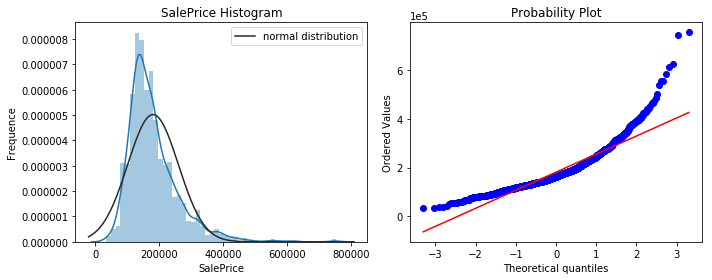

In [7]:
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

# plot histogram and Q-Q plot
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.distplot(df_train['SalePrice'], fit=norm, ax=ax1)
ax1.legend(['normal distribution'], loc='best')
ax1.set_ylabel('Frequence')
ax1.set_title('SalePrice Histogram')
res = stats.probplot(df_train['SalePrice'], plot=ax2)
ax2.yaxis.get_major_formatter().set_powerlimits((0,1))
plt.tight_layout()
# plt.savefig('../fig/SalePrice_plot.eps')

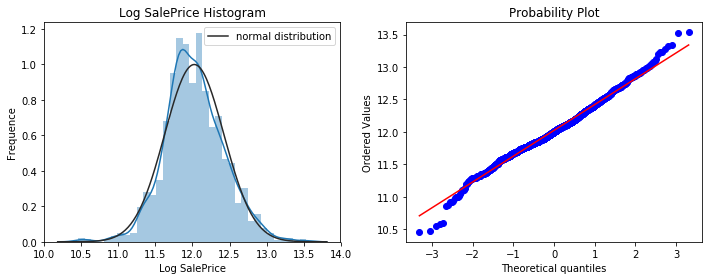

In [8]:
# log transformation
df_train["SalePrice"] = np.log(df_train["SalePrice"])

# check the new distribution 
# plot histogram and Q-Q plot
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.distplot(df_train['SalePrice'], fit=norm, ax=ax1)
ax1.legend(['normal distribution'], loc='best')
ax1.set_xlabel('Log SalePrice')
ax1.set_ylabel('Frequence')
ax1.set_title('Log SalePrice Histogram')
res = stats.probplot(df_train['SalePrice'], plot=ax2)
plt.tight_layout()
# plt.savefig('../fig/SalePrice_log_plot.eps')

## Process missing data

### Overall condition

In [9]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
print('The number of features with missing data: %d' % all_data_na.shape[0])
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

The number of features with missing data: 34


,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


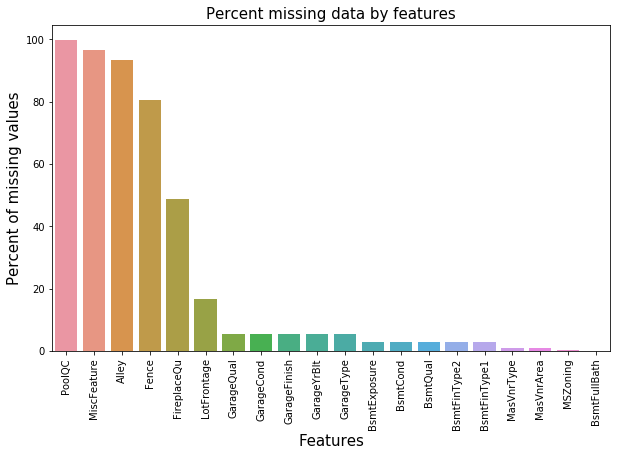

In [10]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index[:20], y=all_data_na[:20])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by features', fontsize=15)
# plt.savefig('../fig/missing_value.eps')
plt.show()

### Impute missing values

In [11]:
# For column X where NA means "No X", fill in None
cols = ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MSSubClass', 'MasVnrType', 
        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2')
for col in cols:
    all_data[col] = all_data[col].fillna('None')

# For column where only few NA values, fill in the most frequent feature
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# GarageYrBlt, GarageArea and GarageCars : fill missing data with 0 (no cars)
# Not sure how to fill GarageYrBlt
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : fill missing data with 0 (no basement)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)


# LotFrontage : Fill in missing values by the median LotFrontage of the neighborhood.
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . 
# Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
if 'Utilities' in all_data.columns:
    all_data = all_data.drop(['Utilities'], axis=1)

# Functional : data description says NA means typical
all_data["Functional"] = all_data["Functional"].fillna("Typ")


#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


## Process categorical data

### Transforming some numerical variables that are really categorical

In [12]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)

# Not sure how to process Year and Month
# all_data['YrSold'] = all_data['YrSold'].astype(str)
# all_data['MoSold'] = all_data['MoSold'].astype(str)
# all_data['GarageYrBlt'] = all_data['GarageYrBlt'].astype(str)

### Label encoding categorical features that have ordering information

In [13]:
# Don't use LabelEncoder, which can't recognize the order
cols = ('ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
        'GarageQual', 'GarageCond', 'PoolQC')
for c in cols:
    all_data[c] = all_data[c].astype('category', ordered=True, 
                                     categories=['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']).cat.codes
    
all_data['BsmtExposure'] = all_data['BsmtExposure'].astype('category', ordered=True, categories=['None', 'No', 'Mn', 'Av', 'Gd']).cat.codes
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].astype('category', ordered=True, categories=['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']).cat.codes
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].astype('category', ordered=True, categories=['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']).cat.codes
all_data['GarageFinish'] = all_data['GarageFinish'].astype('category', ordered=True, categories=['None', 'Unf', 'RFn', 'Fin']).cat.codes
all_data['Fence'] = all_data['Fence'].astype('category', ordered=True, categories=['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']).cat.codes
all_data['Functional'] = all_data['Functional'].astype('category', ordered=True, categories=['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']).cat.codes
all_data['LandSlope'] = all_data['LandSlope'].astype('category', ordered=True, categories=['Sev', 'Mod', 'Gtl']).cat.codes
all_data['LotShape'] = all_data['LotShape'].astype('category', ordered=True, categories=['IR3', 'IR2', 'IR1', 'Reg']).cat.codes
all_data['PavedDrive'] = all_data['PavedDrive'].astype('category', ordered=True, categories=['N', 'P', 'Y']).cat.codes
# Not sure whether the following features should be considered as ordered categorical features
# all_data['LandContour'] = all_data['LandContour'].astype('category', ordered=True, categories=['Low', 'HLS', 'Bnk', 'Lvl']).cat.codes
# all_data['Utilities'] = all_data['Utilities'].astype('category', ordered=True, categories=['ELO', 'NoSeWa', 'NoSeWr', 'AllPub']).cat.codes
# all_data['Street'] = all_data['Street'].astype('category', ordered=True, categories=['Grvl', 'Pave']).cat.codes
# all_data['Alley'] = all_data['Alley'].astype('category', ordered=True, categories=['NA', 'Grvl', 'Pave']).cat.codes

# Check if there is any wrong
all_cate_columns = ('ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 
                    'GarageQual', 'GarageCond', 'PoolQC', 'BsmtExposure','BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 
                    'Fence', 'Functional', 'LandSlope', 'LotShape', 'PavedDrive')
for c in all_cate_columns:
    if -1 in set(all_data[c].values):
        print("{} column is wrong!".format(c))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 78)


In [14]:
# Split numerical features and categorical_features
categorical_features = all_data.select_dtypes(include = ["object"]).columns
numerical_features = all_data.select_dtypes(exclude = ["object"]).columns
print('Numerical features : ' + str(len(numerical_features)))
print('Categorical features : ' + str(len(categorical_features)))
all_data_num = all_data[numerical_features]
all_data_cat = all_data[categorical_features]

Numerical features : 54
Categorical features : 24


### One-hot encoding categorical features that don't have ordering information

In [15]:
all_data_cat = pd.get_dummies(all_data_cat)
print('Shape all_data_cat: {}'.format(all_data_cat.shape))

Shape all_data_cat: (2919, 185)


## Process numerical data

Shape corrmat: (55, 55)


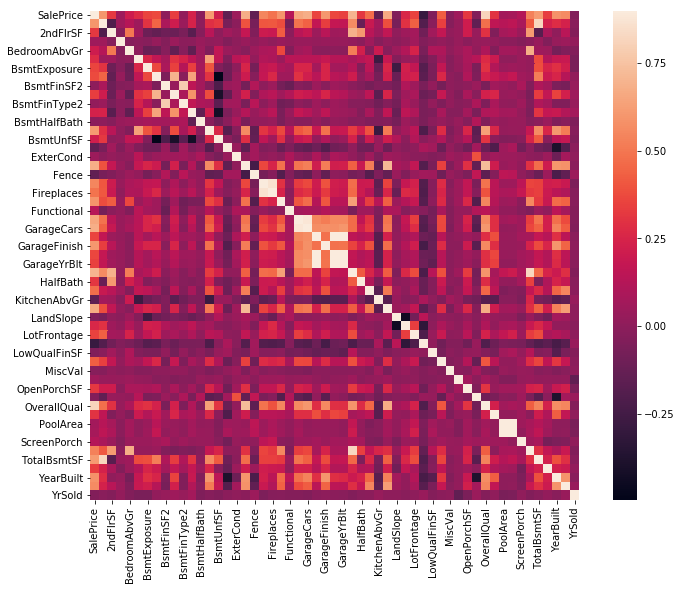

In [16]:
#Correlation map to see how features are correlated with SalePrice
df_train_new = pd.concat([df_train.SalePrice, all_data_num[:ntrain]], axis=1)
corrmat = df_train_new.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
print('Shape corrmat: {}'.format(corrmat.shape))

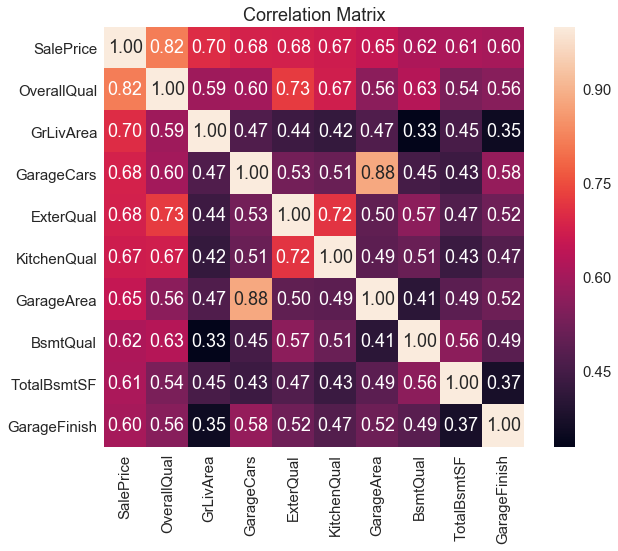

In [17]:
# saleprice correlation matrix
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train_new[cols].values.T)

plt.figure(figsize=[10, 8])
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
plt.title('Correlation Matrix')
plt.tight_layout()
# plt.savefig('../fig/corr_matrix.eps')
plt.show()

In [18]:
sorted_corr = corrmat.sort_values(["SalePrice"], ascending = False)
print(sorted_corr.SalePrice[:10])

SalePrice       1.000000
OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
ExterQual       0.678840
KitchenQual     0.667893
GarageArea      0.650888
BsmtQual        0.615804
TotalBsmtSF     0.612134
GarageFinish    0.604878
Name: SalePrice, dtype: float64


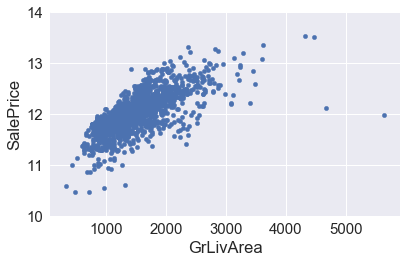

In [19]:
# Relationship with numerical variables: scatter plot
var = 'GrLivArea'
data = pd.concat([df_train_new['SalePrice'], df_train_new[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(10,14))
plt.tight_layout()
# plt.savefig('../fig/scatter_plot.eps')
plt.show()

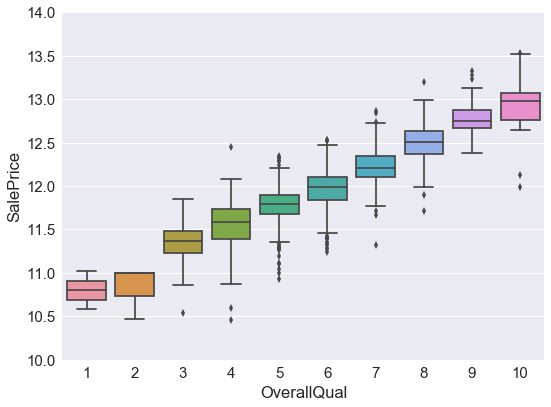

In [20]:
# Relationship with categorical features: box plot
var = 'OverallQual'
data = pd.concat([df_train_new['SalePrice'], df_train_new[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=10, ymax=14)
plt.tight_layout()
# plt.savefig('../fig/box_plot.eps')
plt.show()

In [21]:
# outliers
df_train[df_train['GrLivArea']>4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,12.126759
691,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,13.534473
1182,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,13.521139
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,11.982929


In [22]:
all_data_num.iloc[df_train[df_train['GrLivArea']>4000].index]

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,PavedDrive,PoolArea,PoolQC,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
523,3138,1538,0,3,3,4,2260.0,0.0,6,1,...,2,0,0,0,11,3138.0,208,2007,2008,2007
691,2444,1872,0,4,3,4,1455.0,0.0,6,1,...,2,0,0,0,10,2444.0,382,1994,1995,2007
1182,2411,2065,0,4,3,3,2096.0,0.0,6,1,...,2,555,5,0,10,2396.0,171,1996,1996,2007
1298,4692,950,0,3,3,4,5644.0,0.0,6,1,...,2,480,4,0,12,6110.0,214,2008,2008,2008


In [23]:
drop_index = df_train[df_train['GrLivArea']>4000].index
all_data_num = all_data_num.drop(drop_index)
all_data_cat = all_data_cat.drop(drop_index)
df_train = df_train.drop(drop_index)

In [24]:
ntrain = ntrain - len(drop_index)
print(all_data_num.shape)
print(all_data_cat.shape)
print(df_train.shape)
print(ntrain)

(2915, 54)
(2915, 185)
(1456, 80)
1456


### Skew features

In [25]:
# Check the skew of all numerical features
skewed_feats = all_data_num.apply(lambda x: skew(x)).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.932147
PoolQC,20.921993
PoolArea,18.701829
LotArea,13.123758
LowQualFinSF,12.080315
3SsnPorch,11.368094
KitchenAbvGr,4.298845
BsmtFinSF2,4.142863
EnclosedPorch,4.000796
ScreenPorch,3.943508


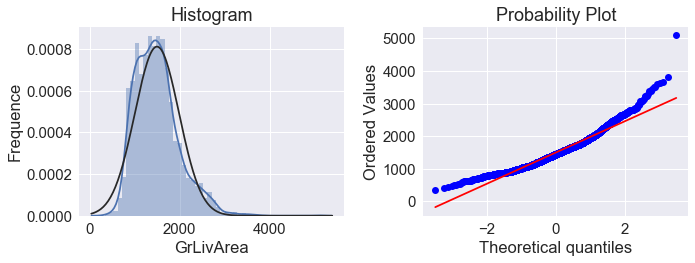

In [26]:
# histogram and normal probability plot
sample_var = 'GrLivArea'
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.distplot(all_data_num[sample_var], fit=norm, ax=ax1)
ax1.set_ylabel('Frequence')
ax1.set_title('Histogram')
res = stats.probplot(all_data_num[sample_var], plot=ax2)
plt.tight_layout()
# plt.savefig('../fig/GrLivArea_plot.eps')

In [27]:
# log transformation of (highly) skewed features
high_skewness = skewness.loc[abs(skewness.Skew) > 1.]
print(str(high_skewness.shape[0]) + " skewed numerical features to log transform")
all_data_num[high_skewness.index] = np.log1p(all_data_num[high_skewness.index])

29 skewed numerical features to log transform


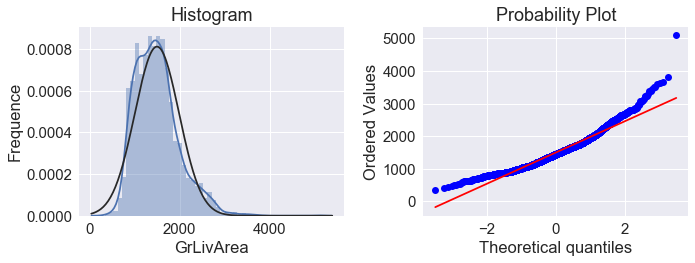

In [28]:
# after log transformation
# histogram and normal probability plot
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.distplot(all_data_num[sample_var], fit=norm, ax=ax1)
ax1.set_ylabel('Frequence')
ax1.set_title('Histogram')
res = stats.probplot(all_data_num[sample_var], plot=ax2)
plt.tight_layout()
# plt.savefig('../fig/GrLivArea_log_plot.eps')

# Train and Evaluate Model

In [29]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [30]:
# Join categorical and numerical features
print("Number of numerical features: {}".format(all_data_num.shape[1]))
print("Number of categorical features: {}".format(all_data_cat.shape[1]))

all_X = pd.concat([all_data_num, all_data_cat], axis=1)
y = df_train.SalePrice
train = all_X[:ntrain]
test = all_X[ntrain:]
print("Shape train_X: {}".format(train.shape))
print("Shape train_y: {}".format(y.shape))
print("Shape test_X: {}".format(test.shape))
# Partition the dataset in train + validation sets
# X_train, X_val, y_train, y_val = train_test_split(train, y, test_size=0.3, random_state=0)
# print("X_train : " + str(X_train.shape))
# print("X_test : " + str(X_test.shape))
# print("y_train : " + str(y_train.shape))
# print("y_test : " + str(y_test.shape))

Number of numerical features: 54
Number of categorical features: 185
Shape train_X: (1456, 239)
Shape train_y: (1456,)
Shape test_X: (1459, 239)


In [31]:
# If wanna do feature selection first with Lasso, after fitting a Lasso model, uncomment following two lines and rerun
# train = train.drop(coefs[coefs == 0].index, axis=1)
# test = test.drop(coefs[coefs == 0].index, axis=1)

In [32]:
# validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=77).split(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv=kf))
    return(rmse)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=0)
def plot_residual_and_prediction(model, X, y, model_name='Linear regression'):
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=0)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Plot residuals
    plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.legend(loc = "upper left")
    plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
    plt.show()

    # Plot predictions
    plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
    plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
    plt.title(model_name)
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.legend(loc = "upper left")
    plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
    plt.show()

### Linear Regression without Regularization

Evaluate RMSE by cross validation: 0.1218
Score list:  [0.12041445 0.12382383 0.11398576 0.12594354 0.12505085]


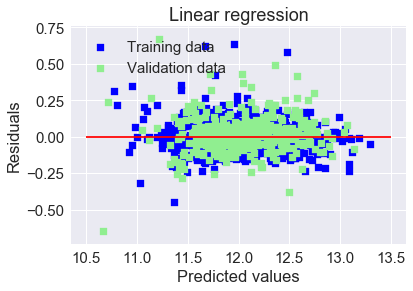

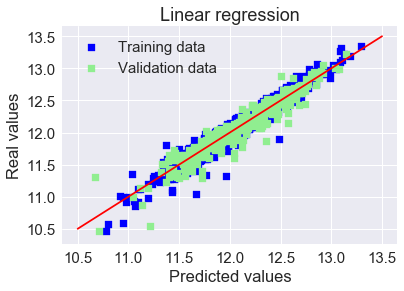

In [34]:
linear_model = LinearRegression()
linear = linear_model
# linear = make_pipeline(RobustScaler(), linear_model)
# linear = make_pipeline(StandardScaler(), linear_model)

rmse_score = rmsle_cv(linear)
print("Evaluate RMSE by cross validation: %.4f" % rmse_score.mean())
print("Score list: ", rmse_score)

plot_residual_and_prediction(linear, train, y, 'Linear regression')

### Ridge Regression (L2-penalty)

In [35]:
test_ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60], cv=10)
test_ridge.fit(train, y)
alpha = test_ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
test_ridge = RidgeCV(alphas=[alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                             alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                             alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                     cv=10)
test_ridge.fit(train, y)
ridge_alpha = test_ridge.alpha_
print("Best alpha :", ridge_alpha)

Best alpha : 6.0
Try again for more precision with alphas centered around 6.0
Best alpha : 6.300000000000001


Evaluate RMSE by cross validation: 0.1108
Score list:  [0.11074681 0.10868651 0.11445331 0.11877227 0.10111348]


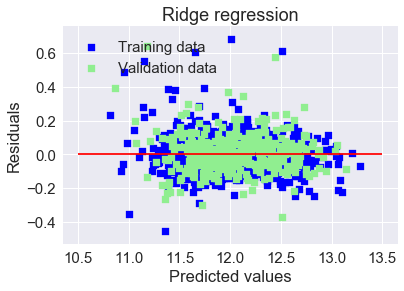

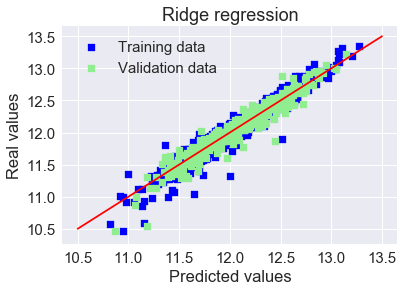

Ridge picked 234 features and eliminated the other 5 features


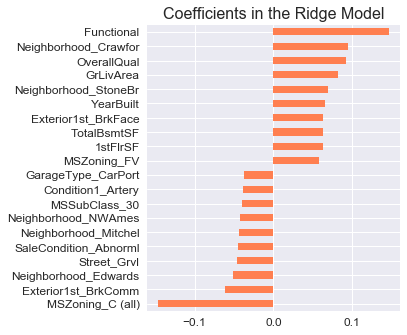

In [36]:
ridge_model = Ridge(alpha=ridge_alpha, random_state=1)
ridge = ridge_model
ridge = make_pipeline(RobustScaler(), ridge_model)
# ridge = make_pipeline(StandardScaler(), ridge_model)

rmse_score = rmsle_cv(ridge)
print("Evaluate RMSE by cross validation: %.4f" %  rmse_score.mean())
print("Score list: ", rmse_score)

plot_residual_and_prediction(ridge, train, y, 'Ridge regression')

# Plot important coefficients
coefs = pd.Series(ridge_model.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", color='coral', fontsize=12, figsize=(6, 5))
plt.title("Coefficients in the Ridge Model", fontsize=16)
plt.tight_layout()
# plt.savefig('../fig/ridge_coef.eps')
plt.show()

### Lasso Regression (L1-penalty)

In [37]:
test_lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                               0.3, 0.6, 1], 
                     cv = 10)
test_lasso.fit(train, y)
alpha = test_lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
test_lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                               alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                               alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                               alpha * 1.4], 
                     max_iter = 50000, cv = 10)
test_lasso.fit(train, y)
lasso_alpha = test_lasso.alpha_
print("Best alpha :", lasso_alpha)

Best alpha : 0.0003
Try again for more precision with alphas centered around 0.0003
Best alpha : 0.00031499999999999996


Evaluate RMSE by cross validation: 0.1099
Score list:  [0.11112882 0.10996159 0.11231512 0.11668031 0.0996484 ]


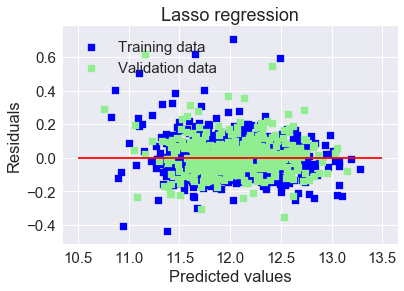

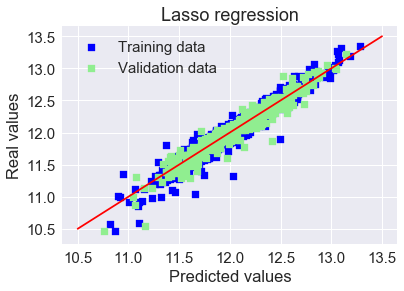

Lasso picked 119 features and eliminated the other 120 features


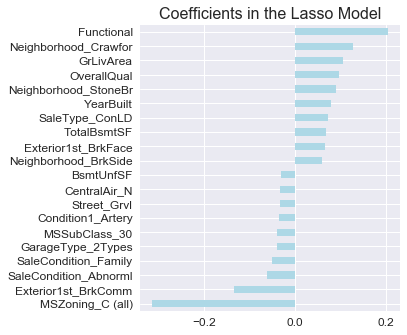

In [38]:
# This model may be very sensitive to outliers. So we need to made it more robust on them. 
# For that we use the sklearn's Robustscaler() method on pipeline
lasso_model = Lasso(alpha=lasso_alpha, random_state=1)
lasso = lasso_model
lasso = make_pipeline(RobustScaler(), lasso_model)
# lasso = make_pipeline(StandardScaler(), lasso_model)

rmse_score = rmsle_cv(lasso)
print("Evaluate RMSE by cross validation: %.4f" % rmse_score.mean())
print("Score list: ", rmse_score)

plot_residual_and_prediction(lasso, train, y, 'Lasso regression')
# Plot important coefficients
coefs = pd.Series(lasso_model.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh", color='lightblue', fontsize=12, figsize=(6, 5))
plt.title("Coefficients in the Lasso Model", fontsize=16)
plt.tight_layout()
# plt.savefig('../fig/lasso_coef.eps')
plt.show()

### Gradient Boosting

In [39]:
# Gradient Boosting Regression:
# With huber loss that makes it robust to outliers
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2,
                             gamma=0.01,
                             learning_rate=0.01,
                             max_depth=4,
                             min_child_weight=1.5,
                             n_estimators=3000,                                                                  
                             reg_alpha=0.5,
                             reg_lambda=0.8,
                             subsample=0.2,
                             seed=42,
                             silent=1)

# Random Forest
randomForest=RandomForestRegressor(n_estimators=3000)

# Light gradient boosting
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.01, n_estimators=3000,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [40]:
score = rmsle_cv(randomForest)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
print(score)

Random Forest score: 0.1371 (0.0082)

[0.13487119 0.13553497 0.15244764 0.1349719  0.12768744]


In [41]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
print(score)

Gradient Boosting score: 0.1135 (0.0074)

[0.113309   0.1083937  0.12177532 0.12121359 0.10268686]


In [42]:
score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
print(score)

XGBoost score: 0.1152 (0.0055)

[0.11429126 0.11396657 0.1193649  0.12235435 0.10608825]


In [43]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))
print(score)

LGBM score: 0.1150 (0.0071)

[0.11410008 0.11039607 0.12173569 0.12398237 0.10488653]


## Stacking models

### Average stacking

In [44]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [45]:
averaged_models = AveragingModels(models=(lasso, GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1073 (0.0064)



In [46]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=77)
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))

        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y.values[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [47]:
stacked_averaged_models = StackingAveragedModels(base_models=(ridge, lasso),
                                                 meta_model=linear)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1097 (0.0057)


In [48]:
stacked_averaged_models = StackingAveragedModels(base_models=(lasso, GBoost),
                                                 meta_model=ridge)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1069 (0.0061)


In [49]:
stacked_averaged_models = StackingAveragedModels(base_models=(lasso, GBoost, model_xgb),
                                                 meta_model=linear)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1068 (0.0061)


In [51]:
stacked_averaged_models = StackingAveragedModels(base_models=(ridge, lasso, GBoost, model_xgb),
                                                 meta_model=linear)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1067 (0.0061)


In [52]:
# predict on test set
stacked_averaged_models.fit(train.values, y)
pred_result = stacked_averaged_models.predict(test.values)

In [53]:
# submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.exp(pred_result)
sub.to_csv('submission.csv', index=False)